<a href="https://colab.research.google.com/github/Sudhandar/EfficientNet-Attention-in-a-Siamese-Network/blob/main/Siamese_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from torch.nn import init
import os 
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from torchsummary import summary
from math import ceil
import torch.nn.functional as F
from statistics import mode
import random
import time
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

In [ ]:
!gdown --id 1nAm_DOaZ4YWFlEW49RZplJX-678mgsy1

In [ ]:
!unzip Colab.zip

In [ ]:
epochs = 20
learning_rate = 0.0001
batch_size = 8
img_size = 224
n_classes = 4
version = "b0"
random_seed = 35
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device Name: {}".format(device))

Device Name: cuda


In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224,224)),
    transforms.Normalize([0.5094, 0.5094, 0.5094], [0.2355, 0.2355, 0.2355]),
    transforms.RandomHorizontalFlip(), 
])

dataset = ImageFolder(root='Colab', transform=transformer)

In [ ]:
len(dataset)

21165

In [ ]:
print(dict(Counter(dataset.targets)))

{0: 3616, 1: 6012, 2: 10192, 3: 1345}


In [ ]:
#Split dataset into train and validation
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.15, stratify=dataset.targets)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [ ]:
#Create DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True, drop_last = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True, drop_last = True)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

17990
3175


In [ ]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            #nn.ReLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [ ]:
class SiameseTrainer():
    def __init__(self, optimizer):
      # self.criterion = criterion
      self.optimizer = optimizer
      # self.schedular = schedular

    def train_one_batch(self, model, x, y, hparams):
      x = x.to(device)
      y = y.to(device)
      batch_embeddings = model(x)
      loss = self.batch_triplet_loss(batch_embeddings, y, hparams)
      
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss.item()

    def validation_one_batch(self, model, x, y, hparams):
      model.eval()
      x = x.to(device)
      y = y.to(device)
      batch_embeddings = model(x)
      loss = self.batch_triplet_loss(batch_embeddings, y, hparams)
      return loss.item()

    def fit(self, model, trainloader, validationloader, hparams):
      train_losses = []
      valid_losses = []
      steps_per_epoch = hparams["steps_per_epoch"]
      valid_min_loss = np.Inf
      for epoch in range(1, hparams["epochs"]+1):
          print('-' * 10)
          print('Epoch {}/{}\t{} batches'.format(epoch, hparams["epochs"], steps_per_epoch))
          model.train()
          curr_loss = []
          for step, (x, y) in enumerate(trainloader):
              loss = self.train_one_batch(model, x, y, hparams)
              curr_loss.append(loss)
              print('\rprogress {:6.1f} %\tloss {:8.4f}'.format(100*(step+1)/steps_per_epoch, np.mean(curr_loss)), end = "")
              
          train_losses.append([epoch,np.mean(curr_loss)])
          print('\rprogress {:6.1f} %\tloss {:8.4f}'.format(100*(step+1)/steps_per_epoch, np.mean(curr_loss)))
          
          model.eval()
          curr_val_loss = []
          for step, (x,y) in enumerate(validationloader):
              loss = self.validation_one_batch(model, x, y, hparams)
              curr_val_loss.append(loss)
              print('\r Validation loss {:8.4f}'.format(np.mean(curr_val_loss)), end = "")
          avg_valid_loss = np.mean(curr_val_loss)
          valid_losses.append([epoch,avg_valid_loss])
          print('\r Validation loss {:8.4f}'.format(np.mean(curr_val_loss)))

          if avg_valid_loss <= valid_min_loss:
              print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
              torch.save(model.state_dict(), "model.pt")
              valid_min_loss = avg_valid_loss

      return train_losses, valid_losses

    def test(self, model, validation_dataloader):
      model.eval()
      X = []; labels = []
      for x, label in validation_dataloader:
          batch_embedings = model(x.to(device))
          X.append(batch_embedings.cpu().detach().numpy())
          labels.append(label.numpy())
      
      X = np.concatenate(X)
      labels = np.concatenate(labels)

      X_reduced = TSNE(n_components=2).fit_transform(X)
      palette = np.array(sns.color_palette("hls", 4))
      plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=palette[labels])
      # plt.legend()
      plt.show()

    def euclidean_dist(self, train_enc, test_enc):
      dist = np.sqrt(np.dot(train_enc-test_enc, (train_enc- test_enc).T))
      return dist

    def get_accuracy(self, x_train, y_train, x_test, y_test):
      # test_distance = []
      predicted_label = []
      print("Calculating Euclidean Distance")
      for i in tqdm(range(len(x_test))):
        distance = []
        for j in range(len(x_train)):
          dist = self.euclidean_dist(x_test[i], x_train[j])
          distance.append(dist)
        closest_idx = np.argsort(distance)
        top_5_closest = []
        for i in range(5):
          top_5_closest.append(y_train[closest_idx[i]])
        most_common_value = Counter(top_5_closest).most_common()[0][0]
        # test_distance.append([i,closest_idx[0],distance[closest_idx[0]],y_train[closest_idx[0]],y_test[i]])
        predicted_label.append(most_common_value)
      predicted_label = np.asarray(predicted_label)
      accuracy = accuracy_score(y_test,predicted_label)
      print("Test Accuracy: ", accuracy * 100)
      print("Classification Report:")
      print(classification_report(y_test, predicted_label, target_names= ["Covid","Other Lung Infection","Normal","Viral Pneumonia"]))
      print("F1 Score: {:.4f}".format(f1_score(y_test, predicted_label, average = "weighted")))


    def test_with_accuracy(self, model, train_dataloader, validation_dataloader):
      model.eval()
      X_train = []; Y_labels = []
      print("Fetching Embeddings")
      for x, label in tqdm(train_dataloader):
          batch_embedings = model(x.to(device))
          X_train.append(batch_embedings.cpu().detach().numpy())
          Y_labels.append(label.numpy())
      X_train_numpy = np.concatenate(X_train)
      Y_labels = np.concatenate(Y_labels)

      X_test_emb = []; Y_test_labels = []
      for x, label in tqdm(validation_dataloader):
          batch_embedings = model(x.to(device))
          X_test_emb.append(batch_embedings.cpu().detach().numpy())
          Y_test_labels.append(label.numpy())

      X_test_emb = np.concatenate(X_test_emb)
      Y_test_labels = np.concatenate(Y_test_labels)
      # print(X_train_numpy.shape, Y_labels.shape, X_test_emb.shape, Y_test_labels.shape)
      self.get_accuracy(X_train_numpy, Y_labels, X_test_emb, Y_test_labels)


    def get_anchor_positive_mask(self,labels):
        indices_equal = torch.eye(labels.size(0), device = "cuda").bool()
        indices_not_equal = ~indices_equal
        labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)

        return labels_equal & indices_not_equal


    def get_anchor_negative_mask(self,labels):
        return ~(labels.unsqueeze(0) == labels.unsqueeze(1))

    def get_triplet_mask(self,labels):
        mask_anchor_positive = self.get_anchor_positive_mask(labels)
        mask_anchor_negative = self.get_anchor_negative_mask(labels)

        return mask_anchor_positive.unsqueeze(2) & mask_anchor_negative.unsqueeze(1)

    def batch_triplet_loss(self,embeddings, labels, hparams):
        
        pairwise_dist = torch.cdist(embeddings, embeddings, p = 1)
        
        if hparams["mode"] == 'batch hard':
            mask_anchor_positive = self.get_anchor_positive_mask(labels).float()
            anchor_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = anchor_positive_dist.max(1, keepdim=True)
            mask_anchor_negative = self.get_anchor_negative_mask(labels).float()
            anchor_negative_dist = pairwise_dist + 999. * (1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = anchor_negative_dist.min(1, keepdim=True)
            
            triplet_loss = hardest_positive_dist - hardest_negative_dist + hparams["margin"]
            
        elif hparams["mode"] == 'batch all':
            anchor_positive_dist = pairwise_dist.unsqueeze(2)
            anchor_negative_dist = pairwise_dist.unsqueeze(1)
            triplet_loss = anchor_positive_dist - anchor_negative_dist + hparams["margin"]
            valid_mask = self.get_triplet_mask(labels).float()
            triplet_loss = valid_mask * triplet_loss
        else:
            raise TypeError("invalid mode")
            
        triplet_loss[triplet_loss < 0] = 0
        return torch.mean(triplet_loss)

In [ ]:
model = EfficientNet(version, n_classes)
model.to(device)

In [ ]:
hparams = {"learning_rate": learning_rate, "margin": 0.8, "mode": "batch all", "batch_size":  batch_size, "epochs": epochs} 
steps_per_epoch  = len(train_dataset)// hparams["batch_size"]
hparams["steps_per_epoch"] = steps_per_epoch
optimizer = torch.optim.AdamW(model.parameters(), hparams['learning_rate'])

In [ ]:
siamese_trainer = SiameseTrainer(optimizer)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


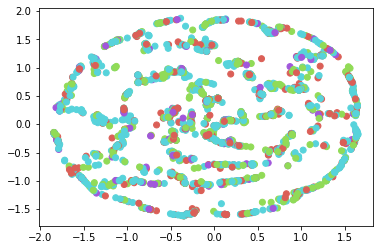

In [ ]:
siamese_trainer.test(model, test_dataloader)

In [ ]:
train_loss_list, validation_loss_list = siamese_trainer.fit(model, train_dataloader, test_dataloader, hparams)

----------
Epoch 1/20	2248 batches
progress  100.0 %	loss   0.1017
progress   17.6 %	loss   0.0701
Valid loss decreased inf --> 0.07009799389734234
----------
Epoch 2/20	2248 batches
progress  100.0 %	loss   0.0675
progress   17.6 %	loss   0.0594
Valid loss decreased 0.07009799389734234 --> 0.05944656380164117
----------
Epoch 3/20	2248 batches
progress  100.0 %	loss   0.0597
progress   17.6 %	loss   0.0513
Valid loss decreased 0.05944656380164117 --> 0.0513457159430607
----------
Epoch 4/20	2248 batches
progress  100.0 %	loss   0.0517
progress   17.6 %	loss   0.0474
Valid loss decreased 0.0513457159430607 --> 0.04735093237597006
----------
Epoch 5/20	2248 batches
progress  100.0 %	loss   0.0483
progress   17.6 %	loss   0.0430
Valid loss decreased 0.04735093237597006 --> 0.042960656608391386
----------
Epoch 6/20	2248 batches
progress  100.0 %	loss   0.0426
progress   17.6 %	loss   0.0397
Valid loss decreased 0.042960656608391386 --> 0.03965802306181168
----------
Epoch 7/20	2248 batch

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


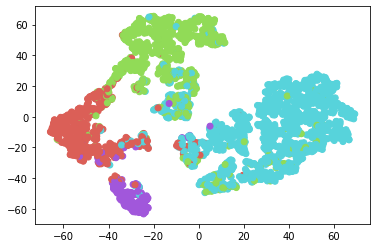

In [ ]:
model.load_state_dict(torch.load('model.pt', map_location = device))
siamese_trainer.test(model, test_dataloader)

In [ ]:
def plot_loss_graphs(training_loss_list,validation_loss_list, title):
  df_stats = pd.DataFrame(training_loss_list, columns = ['epoch','training_loss'])
  df_stats_val = pd.DataFrame(validation_loss_list, columns = ['epoch','validation_loss'])
  df_stats = pd.merge(df_stats, df_stats_val, on = 'epoch', how = 'inner')

  sns.set(style='darkgrid')
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (8,4)
  plt.plot(df_stats['epoch'],df_stats['training_loss'], 'b-o', label="Training")
  plt.plot(df_stats['epoch'],df_stats['validation_loss'], 'g-o', label="Validation")

  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([i for i in df_stats['epoch']])
  plt.show()

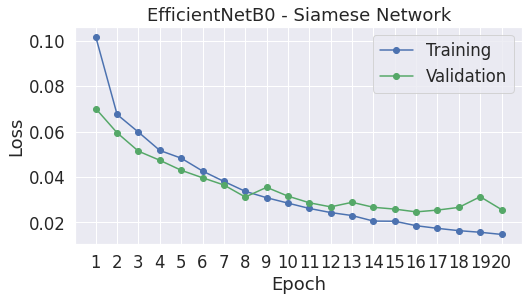

In [ ]:
plot_loss_graphs(train_loss_list,validation_loss_list, "EfficientNetB0 - Siamese Network")

In [ ]:
siamese_trainer.test_with_accuracy(model, train_dataloader, test_dataloader)

Fetching Embeddings


  0%|          | 0/2248 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

Calculating Euclidean Distance


  0%|          | 0/3168 [00:00<?, ?it/s]

Test Accuracy:  89.42550505050505
Classification Report:
                      precision    recall  f1-score   support

               Covid       0.90      0.89      0.89       541
Other Lung Infection       0.87      0.84      0.86       900
              Normal       0.91      0.93      0.92      1525
     Viral Pneumonia       0.90      0.89      0.89       202

            accuracy                           0.89      3168
           macro avg       0.89      0.89      0.89      3168
        weighted avg       0.89      0.89      0.89      3168

F1 Score: 0.8940


## EfficientNetB0 with Attention - Siamese Network

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

class _GridAttentionBlockND(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(_GridAttentionBlockND, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_debug', 'concatenation_residual']

        # Downsampling rate for the input featuremap
        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        # Default parameter set
        self.mode = mode
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # Output transform
        self.W = nn.Sequential(
            conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )

        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Initialise weights
        for m in self.children():
            init_weights(m, init_type='kaiming')

        # Define the operation
        if mode == 'concatenation':
            self.operation_function = self._concatenation
        elif mode == 'concatenation_debug':
            self.operation_function = self._concatenation_debug
        elif mode == 'concatenation_residual':
            self.operation_function = self._concatenation_residual
        else:
            raise NotImplementedError('Unknown operation function.')


    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''

        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = F.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f

    def _concatenation_debug(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.softplus(theta_x + phi_g)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = F.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


    def _concatenation_residual(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        f = self.psi(f).view(batch_size, 1, -1)
        sigm_psi_f = F.softmax(f, dim=2).view(batch_size, 1, *theta_x.size()[2:])

        # upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


class GridAttentionBlock2D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(GridAttentionBlock2D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=2, mode=mode,
                                                   sub_sample_factor=sub_sample_factor,
                                                   )


class GridAttentionBlock3D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(GridAttentionBlock3D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=3, mode=mode,
                                                   sub_sample_factor=sub_sample_factor,
                                                   )

class _GridAttentionBlockND_TORR(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation_mean',
                 sub_sample_factor=(1,1,1), bn_layer=True, use_W=True, use_phi=True, use_theta=True, use_psi=True, nonlinearity1='relu'):
        super(_GridAttentionBlockND_TORR, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_softmax',
                        'concatenation_sigmoid', 'concatenation_mean',
                        'concatenation_range_normalise', 'concatenation_mean_flow']

        # Default parameter set
        self.mode = mode
        self.dimension = dimension
        self.sub_sample_factor = sub_sample_factor if isinstance(sub_sample_factor, tuple) else tuple([sub_sample_factor])*dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # initialise id functions
        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.W = lambda x: x
        self.theta = lambda x: x
        self.psi = lambda x: x
        self.phi = lambda x: x
        self.nl1 = lambda x: x

        if use_W:
            if bn_layer:
                self.W = nn.Sequential(
                    conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
                    bn(self.in_channels),
                )
            else:
                self.W = conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0)

        if use_theta:
            self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                                 kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)


        if use_phi:
            self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                               kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)


        if use_psi:
            self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)


        if nonlinearity1:
            if nonlinearity1 == 'relu':
                self.nl1 = lambda x: F.relu(x, inplace=True)

            elif nonlinearity1 == 'leakyrelu':
                self.nl1 = lambda x: F.leaky_relu(x, negative_slope = 0.01, inplace=True)


        if 'concatenation' in mode:
            self.operation_function = self._concatenation
        else:
            raise NotImplementedError('Unknown operation function.')

        # Initialise weights
        for m in self.children():
            init_weights(m, init_type='kaiming')


        if use_psi and self.mode == 'concatenation_sigmoid':
            nn.init.constant(self.psi.bias.data, 3.0)

        if use_psi and self.mode == 'concatenation_softmax':
            nn.init.constant(self.psi.bias.data, 10.0)

        if use_psi and self.mode == 'concatenation_mean':
            nn.init.constant(self.psi.bias.data, 3.0)

        if use_psi and self.mode == 'concatenation_range_normalise':
            nn.init.constant(self.psi.bias.data, 3.0)

        parallel = False
        if parallel:
            if use_W: self.W = nn.DataParallel(self.W)
            if use_phi: self.phi = nn.DataParallel(self.phi)
            if use_psi: self.psi = nn.DataParallel(self.psi)
            if use_theta: self.theta = nn.DataParallel(self.theta)

    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''

        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        #############################
        # compute compatibility score

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w)
        # phi   => (b, c, t, h, w) -> (b, i_c, t, h, w)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        #  nl(theta.x + phi.g + bias) -> f = (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)

        f = theta_x + phi_g
        f = self.nl1(f)

        psi_f = self.psi(f)

        ############################################
        # normalisation -- scale compatibility score
        #  psi^T . f -> (b, 1, t/s1, h/s2, w/s3)
        if self.mode == 'concatenation_softmax':
            sigm_psi_f = F.softmax(psi_f.view(batch_size, 1, -1), dim=2)
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
        elif self.mode == 'concatenation_mean':
            psi_f_flat = psi_f.view(batch_size, 1, -1)
            psi_f_sum = torch.sum(psi_f_flat, dim=2)#clamp(1e-6)
            psi_f_sum = psi_f_sum[:,:,None].expand_as(psi_f_flat)

            sigm_psi_f = psi_f_flat / psi_f_sum
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
        elif self.mode == 'concatenation_mean_flow':
            psi_f_flat = psi_f.view(batch_size, 1, -1)
            ss = psi_f_flat.shape
            psi_f_min = psi_f_flat.min(dim=2)[0].view(ss[0],ss[1],1)
            psi_f_flat = psi_f_flat - psi_f_min
            psi_f_sum = torch.sum(psi_f_flat, dim=2).view(ss[0],ss[1],1).expand_as(psi_f_flat)

            sigm_psi_f = psi_f_flat / psi_f_sum
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
        elif self.mode == 'concatenation_range_normalise':
            psi_f_flat = psi_f.view(batch_size, 1, -1)
            ss = psi_f_flat.shape
            psi_f_max = torch.max(psi_f_flat, dim=2)[0].view(ss[0], ss[1], 1)
            psi_f_min = torch.min(psi_f_flat, dim=2)[0].view(ss[0], ss[1], 1)

            sigm_psi_f = (psi_f_flat - psi_f_min) / (psi_f_max - psi_f_min).expand_as(psi_f_flat)
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])

        elif self.mode == 'concatenation_sigmoid':
            sigm_psi_f = F.sigmoid(psi_f)
        else:
            raise NotImplementedError

        # sigm_psi_f is attention map! upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


class GridAttentionBlock2D_TORR(_GridAttentionBlockND_TORR):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(1,1), bn_layer=True,
                 use_W=True, use_phi=True, use_theta=True, use_psi=True,
                 nonlinearity1='relu'):
        super(GridAttentionBlock2D_TORR, self).__init__(in_channels,
                                               inter_channels=inter_channels,
                                               gating_channels=gating_channels,
                                               dimension=2, mode=mode,
                                               sub_sample_factor=sub_sample_factor,
                                               bn_layer=bn_layer,
                                               use_W=use_W,
                                               use_phi=use_phi,
                                               use_theta=use_theta,
                                               use_psi=use_psi,
                                               nonlinearity1=nonlinearity1)


class GridAttentionBlock3D_TORR(_GridAttentionBlockND_TORR):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(1,1,1), bn_layer=True):
        super(GridAttentionBlock3D_TORR, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=3, mode=mode,
                                                   sub_sample_factor=sub_sample_factor,
                                                   bn_layer=bn_layer)

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            # nn.ReLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


In [ ]:
class EfficientNetAttention(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetAttention, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors("b0")
        last_channels = ceil(1280 * width_factor)
        self.initial_layer = CNNBlock(3, 32, 3, stride=2, padding=1)

        self.irb1 = InvertedResidualBlock( 32, 16 , expand_ratio=1, stride = 1, kernel_size= 3, padding= 1,)
        self.irb2 = InvertedResidualBlock( 16, 24 , expand_ratio=6, stride = 2, kernel_size= 3, padding= 1,)
        self.irb3 = InvertedResidualBlock( 24, 24 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
        self.irb4 = InvertedResidualBlock( 24, 40 , expand_ratio=6, stride = 2, kernel_size= 5, padding= 2,)
        self.irb5 = InvertedResidualBlock( 40, 40 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb6 = InvertedResidualBlock( 40, 80 , expand_ratio=6, stride = 2, kernel_size= 3, padding= 1,)
        self.irb7 = InvertedResidualBlock( 80, 80 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
        self.irb8 = InvertedResidualBlock( 80, 80 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
        self.irb9 = InvertedResidualBlock( 80, 112 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb10 = InvertedResidualBlock( 112, 112 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb11 = InvertedResidualBlock( 112, 112 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb12 = InvertedResidualBlock( 112, 192 , expand_ratio=6, stride = 2, kernel_size= 5, padding= 2,)
        self.irb13 = InvertedResidualBlock( 192, 192 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb14 = InvertedResidualBlock( 192, 192 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb15 = InvertedResidualBlock( 192, 192 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb16 = InvertedResidualBlock( 192, 320 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
   
        self.final_layer = CNNBlock(320, last_channels, kernel_size=1, stride=1, padding=0)
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.compatibility_score1 = GridAttentionBlock2D_TORR(in_channels=192, gating_channels=1280,
                                                     inter_channels=1280, sub_sample_factor=(3, 3),
                                                     mode='concatenation_mean_flow', use_W=True, use_phi=True,
                                                     use_theta=True, use_psi=True, nonlinearity1='leakyrelu')

        self.compatibility_score2 = GridAttentionBlock2D_TORR(in_channels=320, gating_channels=1280,
                                                     inter_channels=1280, sub_sample_factor=(3,3),
                                                     mode='concatenation_mean_flow', use_W=True, use_phi=True,
                                                     use_theta=True, use_psi=True, nonlinearity1='leakyrelu')
        
        self.classifier = nn.Linear(192 + 320 + 1280, n_classes)
        self.aggregate = self.aggregation_concat

    def aggregation_concat(self, *attended_maps):
        return self.classifier(torch.cat(attended_maps, dim=1))


    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.irb1(x)
        x = self.irb2(x)
        x = self.irb3(x)
        x = self.irb4(x)
        x = self.irb5(x)
        x = self.irb6(x)
        x = self.irb7(x)
        x = self.irb8(x)
        x = self.irb9(x)
        x = self.irb10(x)
        x = self.irb11(x)
        x = self.irb12(x)
        x = self.irb13(x)
        x = self.irb14(x)
        antepenultimate_value = self.irb15(x)
        penultimate_value = self.irb16(antepenultimate_value)
        final_value = self.final_layer(penultimate_value)
        pooled_value = self.pool(final_value)
        pooled_value = pooled_value.view(pooled_value.shape[0],pooled_value.shape[1])
        g_conv1, att1 = self.compatibility_score1(antepenultimate_value, final_value)
        g_conv2, att2 = self.compatibility_score2(penultimate_value, final_value)
        g1 = torch.sum(g_conv1.view(g_conv1.shape[0],g_conv1.shape[1],-1), dim=-1)
        g2 = torch.sum(g_conv2.view(g_conv2.shape[0],g_conv2.shape[1],-1), dim=-1)
        x = self.aggregate(g1, g2, pooled_value)
        return x

In [ ]:
model = EfficientNetAttention(4)
model.to(device)

In [ ]:
hparams = {"learning_rate": learning_rate, "margin": 0.8, "mode": "batch all", "batch_size":  batch_size, "epochs": epochs} 
steps_per_epoch  = len(train_dataset)// hparams["batch_size"]
hparams["steps_per_epoch"] = steps_per_epoch
optimizer = torch.optim.AdamW(model.parameters(), hparams['learning_rate'])

In [ ]:
siamese_trainer = SiameseTrainer(optimizer)

In [ ]:
# siamese_trainer.test(model, test_dataloader)

In [ ]:
train_loss_list, validation_loss_list = siamese_trainer.fit(model, train_dataloader, test_dataloader, hparams)

----------
Epoch 1/20	2248 batches


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


progress  100.0 %	loss   0.2838
 Validation loss   0.1141
Valid loss decreased inf --> 0.11405732496665094
----------
Epoch 2/20	2248 batches
progress  100.0 %	loss   0.1046
 Validation loss   0.0737
Valid loss decreased 0.11405732496665094 --> 0.07371018812262613
----------
Epoch 3/20	2248 batches
progress  100.0 %	loss   0.0792
 Validation loss   0.0652
Valid loss decreased 0.07371018812262613 --> 0.0652129396789171
----------
Epoch 4/20	2248 batches
progress  100.0 %	loss   0.0681
 Validation loss   0.0551
Valid loss decreased 0.0652129396789171 --> 0.05507943877242411
----------
Epoch 5/20	2248 batches
progress  100.0 %	loss   0.0592
 Validation loss   0.0463
Valid loss decreased 0.05507943877242411 --> 0.04633920049445346
----------
Epoch 6/20	2248 batches
progress  100.0 %	loss   0.0522
 Validation loss   0.0412
Valid loss decreased 0.04633920049445346 --> 0.04120469934305863
----------
Epoch 7/20	2248 batches
progress  100.0 %	loss   0.0441
 Validation loss   0.0428
----------
E

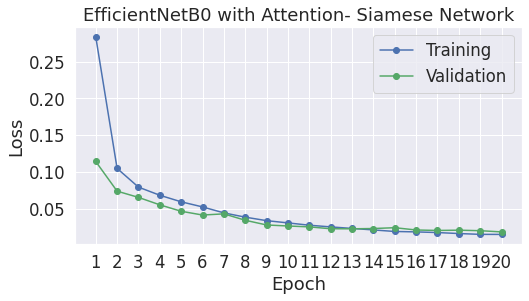

In [ ]:
plot_loss_graphs(train_loss_list,validation_loss_list, "EfficientNetB0 with Attention- Siamese Network")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


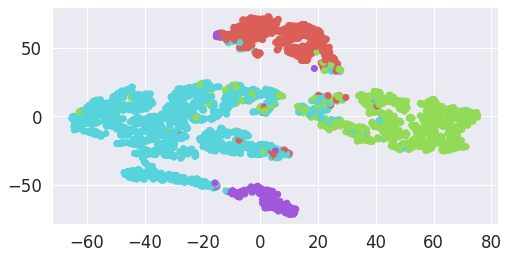

In [ ]:
model.load_state_dict(torch.load('model.pt', map_location = device))
siamese_trainer.test(model, test_dataloader)

In [ ]:
siamese_trainer.test_with_accuracy(model, train_dataloader, test_dataloader)

Fetching Embeddings


  0%|          | 0/2248 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


  0%|          | 0/396 [00:00<?, ?it/s]

Calculating Euclidean Distance


  0%|          | 0/3168 [00:00<?, ?it/s]

Test Accuracy:  92.64520202020202
Classification Report:
                      precision    recall  f1-score   support

               Covid       0.95      0.93      0.94       542
Other Lung Infection       0.91      0.89      0.90       899
              Normal       0.92      0.95      0.93      1525
     Viral Pneumonia       0.96      0.94      0.95       202

            accuracy                           0.93      3168
           macro avg       0.94      0.93      0.93      3168
        weighted avg       0.93      0.93      0.93      3168

F1 Score: 0.9263
